## 05-02 TensorBoard

In [30]:
%matplotlib inline
import os
import time
from pathlib import Path

import numpy as  np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


### 1.TensorBoard Test

In [4]:
writer = SummaryWriter(comment='tensorboard_test')

for x in range(100):
    writer.add_scalar('y=2x', x * 2, x)
    writer.add_scalar('y=pow(2, x', 2 ** x, x)
    writer.add_scalars('data/scalar_group', {
        'xsinx': x * np.sin(x),
        'xcosx': x * np.cos(x),
        'arctanx': np.arctan(x)
    }, x)

writer.close()

### 2.TensorBoard Method

SummaryWriter的使用

In [3]:
writer = SummaryWriter(comment='_scalars', filename_suffix='12345678')
for x in range(100):
    writer.add_scalar('y=pow_2_x', 2 ** x, x)
writer.close()

scalar和scalars的使用

In [4]:
max_epoch = 100
writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')
for x in range(max_epoch):
    writer.add_scalar('y=2x', x * 2, x)
    writer.add_scalar('y=pow_2_x', 2 ** x, x)
    writer.add_scalars('data/scalar_group', {
        'xsinx': x * np.sin(x),
        'xcosx': x * np.cos(x)
    }, x)
writer.close()

histogram的使用

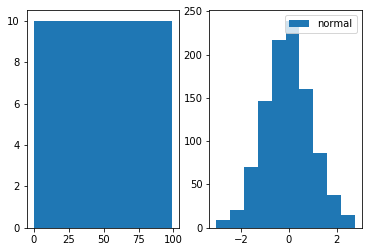

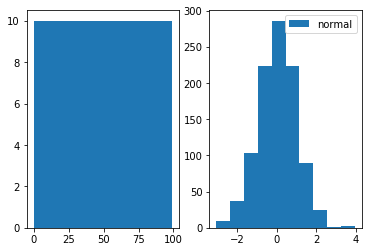

In [10]:
writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')
for x in range(2):
    np.random.seed(x)
    data_union = np.arange(100)
    data_normal = np.random.normal(size=1000)

    writer.add_histogram('union', data_union, x)
    writer.add_histogram('normal', data_normal, x)

    plt.subplot(121).hist(data_union, label='union')
    plt.subplot(122).hist(data_normal, label='normal')
    plt.legend()
    plt.show()

writer.close()

image的使用

In [5]:
writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')

fake_img = torch.randn(3, 512, 512)
writer.add_image('fake_image', fake_img, 1)
time.sleep(1)

fake_img = torch.ones(3, 512, 512)
writer.add_image('fake_image', fake_img, 2)
time.sleep(1)

fake_img = torch.ones(3, 512, 512) * 1.1
writer.add_image('fake_image', fake_img, 3)
time.sleep(1)

fake_img = torch.rand(512, 512)
writer.add_image('fake_image', fake_img, 4, dataformats='HW')
time.sleep(1)

fake_img = torch.rand(512, 512, 3)
writer.add_image('fake_image', fake_img, 5, dataformats='HWC')
time.sleep(1)

writer.close()

make_grid的使用

In [17]:
rmb_data_path = Path('/media/bnu/file/datasets/pytorch-tutorials/rmb_data')
split_path = rmb_data_path / 'split_data'
train_path = split_path / 'train'

class RMBDataset(Dataset):
    
    def __init__(self, image_path, transform=None):
        self.label_dict = {'1': 0, '100': 1}
        self.transform = transform

        self.image_data = []
        for root, dirs, files in os.walk(image_path):
            for sub_dir in dirs:
                # 获取目录下所有图片列表
                image_file_list = os.listdir(image_path / sub_dir)
                image_file_list = list(filter(lambda x: x.endswith('.jpg'), image_file_list))

                # 保存每个图片的路径和标签
                for i in range(len(image_file_list)):
                    image_name = image_file_list[i]
                    file_path = image_path / sub_dir / image_name
                    label = self.label_dict[sub_dir]
                    self.image_data.append((file_path, label))

    def __getitem__(self, index):
        file_path, label = self.image_data[index]
        image = Image.open(file_path).convert('RGB')  # 数据范围0-255
        
        # 对图片进行transform
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.image_data)


train_transforms = transforms.Compose([
    transforms.Resize((32, 64)),
    transforms.ToTensor()
])
train_data = RMBDataset(train_path, transform=train_transforms)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
data_batch, _ = next(iter(train_loader))

img_grid = vutils.make_grid(data_batch, nrow=4, normalize=False, scale_each=False)

writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')
writer.add_image('input img', img_grid, 0)
writer.close()

graph的使用

In [31]:
class LeNet(nn.Module):
    
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

fake_img = torch.randn(1, 3, 32, 32)
lenet = LeNet(num_classes=2)
writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')
writer.add_graph(lenet, fake_img)
writer.close()

### 3.TensorBoard Visualization

kernel visualization

In [24]:
writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')

alexnet = models.alexnet(pretrained=True)
kernel_num, vis_max = -1, 1

for sub_module in alexnet.modules():
    if isinstance(sub_module, nn.Conv2d):
        kernel_num += 1
        if kernel_num > vis_max:
            break
        kernels = sub_module.weight
        c_out, c_input, k_w, k_h = tuple(kernels.shape)

        for o_idx in range(c_out):
            kernel_idx = kernels[o_idx, :, :, :].unsqueeze(1)
            kernel_grid = vutils.make_grid(kernel_idx, normalize=True, scale_each=True, nrow=c_input)
            writer.add_image('{}_Conv_Split_in_Channel'.format(kernel_num), kernel_grid, global_step=o_idx)

        kernel_all = kernels.view(-1, 3, k_h, k_w)
        kernel_grid = vutils.make_grid(kernel_all, normalize=True, scale_each=True, nrow=8)
        writer.add_image('{}_All'.format(kernel_num), kernel_grid, global_step=322)
        print('{}_Conv Shape: {}'.format(kernel_num, tuple(kernels.shape)))

writer.close()

0_Conv Shape: (64, 3, 11, 11)
1_Conv Shape: (192, 64, 5, 5)


feature map visualization

In [28]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.49139968, 0.48215827, 0.44653124],
        [0.24703233, 0.24348505, 0.26158768]
    )
])

image_path = Path('./image/lena.png')
img_pil = Image.open(image_path).convert('RGB')
img_tensor = image_transforms(img_pil)
img_tensor.unsqueeze_(0)

alexnet = models.alexnet(pretrained=True)
convlayer1 = alexnet.features[0]
fmap_1 = convlayer1(img_tensor)

fmap_1.transpose_(0, 1)
fmap_1_grid = vutils.make_grid(fmap_1, normalize=True, scale_each=True, nrow=8)

writer = SummaryWriter(comment='test_comment', filename_suffix='test_suffix')
writer.add_image('feature map in conv1', fmap_1_grid, global_step=322)
writer.close()